# 4 - Hipocamp_FEATURES__EXTRACT

In [2]:
import os  # needed navigate the system to get the input data
import glob

import matplotlib.pyplot as plt
from ipywidgets import widgets, interact
%matplotlib inline

import numpy as np
import pandas as pd
#import six

import nibabel as nib

In [3]:
#constants
PATH_SCANS = "/notebooks/disk2/DS2_FreeSurfer/"
#PATH_SCANS = "/notebooks/disk2/Paulo_MCI_AD/DS2_FreeSurfer/"

# Additonally, store the location of the example parameter file, stored in \pyradiomics\bin
#PATH_PARAM = os.path.join(os.getcwd(), "..", "Params.yaml")
PATH_PARAM = "params.yaml"
print("Parameter file, absolute path:", os.path.abspath(PATH_PARAM))

PATH_CSV_FREESURFER_FILES = 'paths_freesurfer.csv'
#PATH_CSV_FREESURFER_FILES = 'paths_freesurfer_valves2.csv'
PATH_CSV_RADIOMICS_ALL = 'D.all_radiomics_segments.csv'

Parameter file, absolute path: /notebooks/disk2/params.yaml


### Setting up data

In [4]:
# Get the paths ".nii.gz"

paths_nii = {}
def percorrePasta_2(pasta, barrasIniciais):
    if barrasIniciais == 0:
        barrasIniciais = len(pasta.split("/"))-1
    files = []
    for f in glob.glob(pasta):
        if(os.path.isdir(f + "/")):
            f = f + "/*"
            files += percorrePasta_2(f, barrasIniciais)
        else:
            if(os.path.splitext(f)[1] == ".gz" ):
                nomeFicheiro = f.split("/")[2+barrasIniciais]
                numeroPaciente = f.split("/")[barrasIniciais][5:15]
                if nomeFicheiro == "aseg.nii.gz" or nomeFicheiro == "brain.nii.gz" :
                    if numeroPaciente not in paths_nii:
                        paths_nii[numeroPaciente] = {"aseg": "", "brain": "", "diretorio": ""}
                    paths_nii[numeroPaciente][nomeFicheiro.replace(".nii.gz", "")] = f
                    paths_nii[numeroPaciente]["diretorio"] = f.replace(nomeFicheiro, "")
                        
    return paths_nii

percorrePasta_2(PATH_SCANS+'*', 0) #paths já está alterado
#percorrePasta("/notebooks/disk2/Paulo_MCI_AD/DS2_FreeSurfer/*", 0) #paths já está alterado
print(paths_nii["006_S_0681"])

{'aseg': '/notebooks/disk2/DS2_FreeSurfer/ADNI_006_S_0681_MR_MP-RAGE__br_raw_20060831143335593_1_S18451_I23677_generate/mri/aseg.nii.gz', 'brain': '/notebooks/disk2/DS2_FreeSurfer/ADNI_006_S_0681_MR_MP-RAGE__br_raw_20060831143335593_1_S18451_I23677_generate/mri/brain.nii.gz', 'diretorio': '/notebooks/disk2/DS2_FreeSurfer/ADNI_006_S_0681_MR_MP-RAGE__br_raw_20060831143335593_1_S18451_I23677_generate/mri/'}
{'aseg': '/notebooks/disk2/DS2_FreeSurfer/ADNI_002_S_0295_MR_MP-RAGE__br_raw_20060418193713091_1_S13408_I13722_generate/mri/aseg.nii.gz', 'brain': '/notebooks/disk2/DS2_FreeSurfer/ADNI_002_S_0295_MR_MP-RAGE__br_raw_20060418193713091_1_S13408_I13722_generate/mri/brain.nii.gz', 'diretorio': '/notebooks/disk2/DS2_FreeSurfer/ADNI_002_S_0295_MR_MP-RAGE__br_raw_20060418193713091_1_S13408_I13722_generate/mri/'}


In [5]:
# label selection
def get_labelnp_from_mgz(labelPath, regionlist):
    nplabel = nib.load(labelPath).get_fdata()
    for reg in regionlist:
        nplabel[nplabel == reg] =-1
    nplabel[nplabel != -1] =0
    nplabel[nplabel == -1] =1
    return nplabel

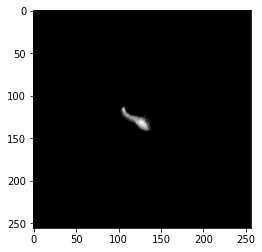

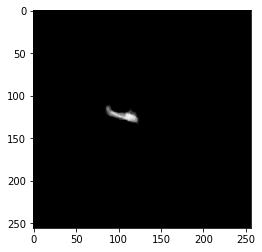

In [6]:
def display_mask(subject):
    label = get_labelnp_from_mgz(paths_nii[subject]["aseg"], [17,53])
    plt.imshow(np.sum((label>0).astype(float), 0), cmap="gray")
    plt.show()

display_mask("006_S_0681")
display_mask("002_S_0295")

In [7]:
# Display the images

list_subject = list(paths_nii.keys())
@interact 
def display_img_mask(subject=list_subject):
    #example ADNI_002_S_0295
    print(paths_nii[subject]["brain"]) 
    img = nib.load(paths_nii[subject]["brain"]).get_fdata()
    print(img.shape)

    print(paths_nii[subject]["aseg"]) 
    label = get_labelnp_from_mgz(paths_nii[subject]["aseg"], [17,53])
    print(label.shape)

    @interact
    def viewer_scan(i=(60,200)):
        plt.figure(figsize=(15,15))
        plt.subplot(2,2,1)
        plt.imshow(img[i,:,:], cmap="gray")        
        plt.title("Img")
        plt.subplot(2,2,2)
        plt.imshow(label[i,:,:])        
        plt.title("Segmentation")
        plt.show()
        


interactive(children=(Dropdown(description='subject', options=('006_S_0681', '941_S_1203', '011_S_0003', '057_…

In [6]:
#save paths in CSV
def create_path_freesurfer_csv(paths_dic,path_csv): 
    colunas = ["ID", "Image", "Mask"]
    df = pd.DataFrame([],columns=colunas)
    for paciente in paths_dic:
        coluna1 = paths_dic[paciente]["brain"]
        coluna2 = paths_dic[paciente]["aseg"]
        lista = [paciente, coluna1, coluna2]
        df.loc[df.shape[0]] = lista 

    df.to_csv(path_csv, index=False)

#create_path_freesurfer_csv(paths_nii,PATH_CSV_FREESURFER_FILES)

### Segment Radiomics Extraction

In [11]:
#from mpl_toolkits.mplot3d import Axes3D
#import seaborn as sns
#import h5py # for reading the image files
#import skimage # for image processing and visualizations
#import sklearn # for machine learning and statistical models

from pathlib import Path # help manage files
from SimpleITK import GetImageFromArray
import radiomics
from radiomics import featureextractor
from radiomics.featureextractor import RadiomicsFeatureExtractor # This module is used for interaction with pyradiomic
import logging
logging.getLogger('radiomics').setLevel(logging.CRITICAL + 1)  # this tool makes a whole TON of log noise

In [12]:
extractor = featureextractor.RadiomicsFeatureExtractor(PATH_PARAM)
print('Extraction parameters:\n\t', extractor.settings)
print('Enabled filters:\n\t', extractor.enabledImagetypes)
print('Enabled features:\n\t', extractor.enabledFeatures)

Extraction parameters:
	 {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
Enabled filters:
	 {'Original': {}, 'Wavelet': {}, 'LoG': {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}, 'Square': {}, 'SquareRoot': {}, 'Logarithm': {}, 'Exponential': {}, 'Gradient': {}, 'LBP2D': {}, 'LBP3D': {}}
Enabled features:
	 {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': [], 'shape2D': []}


In [13]:
%%time
#TEST1

def calc_radiomics(in_image_data, in_mask_data):
    return extractor.execute(GetImageFromArray(in_image_data),
                            GetImageFromArray((in_mask_data>0).astype(np.uint8)))

def calc_radiomics_files(in_image_file, in_mask_file):
    img = nib.load(in_image_file).get_fdata()
    mask = get_labelnp_from_mgz(in_mask_file, [17,53])
    return extractor.execute(GetImageFromArray(img),
                            GetImageFromArray((mask>0).astype(np.uint8)))

def test_rad_extration(subject):
    img = nib.load(paths_nii[subject]["brain"]).get_fdata()
    mask = get_labelnp_from_mgz(paths_nii[subject]["aseg"], [17,53])
    results = calc_radiomics((img,mask))
    return pd.DataFrame([results]).T

def test_rad_extration_files(subject):
    results = calc_radiomics_files(paths_nii[subject]["brain"],paths_nii[subject]["aseg"])
    return pd.DataFrame([results]).T

#test_rad_extration("006_S_0681")
test_rad_extration_files("006_S_0681")

CPU times: user 45.3 s, sys: 7.83 s, total: 53.2 s
Wall time: 29.2 s


,0
diagnostics_Versions_PyRadiomics,2.2.0
diagnostics_Versions_Numpy,1.18.5
diagnostics_Versions_SimpleITK,1.2.4
diagnostics_Versions_PyWavelet,1.1.1
diagnostics_Versions_Python,3.7.7
...,...
lbp-3D-k_ngtdm_Busyness,479.4149348871241
lbp-3D-k_ngtdm_Coarseness,0.0015375760657813805
lbp-3D-k_ngtdm_Complexity,0.1830493463704923
lbp-3D-k_ngtdm_Contrast,0.01704371328947926


In [36]:
%%time
#TEST2

test_rad_extration("941_S_1203")

CPU times: user 44.3 s, sys: 3.57 s, total: 47.8 s
Wall time: 24.1 s


,0
diagnostics_Versions_PyRadiomics,v3.0.1
diagnostics_Versions_Numpy,1.21.5
diagnostics_Versions_SimpleITK,1.2.4
diagnostics_Versions_PyWavelet,1.0.0
diagnostics_Versions_Python,3.7.7
...,...
lbp-3D-k_ngtdm_Busyness,378.0017629164192
lbp-3D-k_ngtdm_Coarseness,0.0017607177534025324
lbp-3D-k_ngtdm_Complexity,0.14602139089675553
lbp-3D-k_ngtdm_Contrast,0.010782222995957543


In [14]:
all_df=pd.read_csv(PATH_CSV_FREESURFER_FILES)
all_df.head() # show the first lines

,ID,Image,Mask
0,006_S_0681,/notebooks/disk2/DS2_FreeSurfer/ADNI_006_S_068...,/notebooks/disk2/DS2_FreeSurfer/ADNI_006_S_068...
1,941_S_1203,/notebooks/disk2/DS2_FreeSurfer/ADNI_941_S_120...,/notebooks/disk2/DS2_FreeSurfer/ADNI_941_S_120...
2,011_S_0003,/notebooks/disk2/DS2_FreeSurfer/ADNI_011_S_000...,/notebooks/disk2/DS2_FreeSurfer/ADNI_011_S_000...
3,057_S_0779,/notebooks/disk2/DS2_FreeSurfer/ADNI_057_S_077...,/notebooks/disk2/DS2_FreeSurfer/ADNI_057_S_077...
4,033_S_0920,/notebooks/disk2/DS2_FreeSurfer/ADNI_033_S_092...,/notebooks/disk2/DS2_FreeSurfer/ADNI_033_S_092...


In [15]:
%%time

all_df['radiomics'] = all_df.apply(lambda row: calc_radiomics_files(row[ "Image"], row["Mask"]) ,axis = 1)

all_df.head() 

CPU times: user 5h 14min 22s, sys: 49min 45s, total: 6h 4min 7s
Wall time: 3h 17min 49s


,ID,Image,Mask,radiomics
0,006_S_0681,/notebooks/disk2/DS2_FreeSurfer/ADNI_006_S_068...,/notebooks/disk2/DS2_FreeSurfer/ADNI_006_S_068...,"{'diagnostics_Versions_PyRadiomics': '2.2.0', ..."
1,941_S_1203,/notebooks/disk2/DS2_FreeSurfer/ADNI_941_S_120...,/notebooks/disk2/DS2_FreeSurfer/ADNI_941_S_120...,"{'diagnostics_Versions_PyRadiomics': '2.2.0', ..."
2,011_S_0003,/notebooks/disk2/DS2_FreeSurfer/ADNI_011_S_000...,/notebooks/disk2/DS2_FreeSurfer/ADNI_011_S_000...,"{'diagnostics_Versions_PyRadiomics': '2.2.0', ..."
3,057_S_0779,/notebooks/disk2/DS2_FreeSurfer/ADNI_057_S_077...,/notebooks/disk2/DS2_FreeSurfer/ADNI_057_S_077...,"{'diagnostics_Versions_PyRadiomics': '2.2.0', ..."
4,033_S_0920,/notebooks/disk2/DS2_FreeSurfer/ADNI_033_S_092...,/notebooks/disk2/DS2_FreeSurfer/ADNI_033_S_092...,"{'diagnostics_Versions_PyRadiomics': '2.2.0', ..."


In [18]:
def cria_CSV_radiomics_all(PATH_CSV_RADIOMICS_ALL,all_df):
    full_df = pd.DataFrame([dict(**c_row.pop('radiomics'), **c_row) for _, c_row in all_df.iterrows()])
    print(full_df.shape, 'data prepared')
    first_cols = all_df.columns[:-1].tolist()
    full_df = full_df[first_cols + [c_col for c_col in full_df.columns if c_col not in first_cols]]
    # export the whole table
    full_df.to_csv('D.all_radiomics_table.csv', index=False)
    return full_df
    full_df.sample(3)

full_df=cria_CSV_radiomics_all(PATH_CSV_RADIOMICS_ALL, all_df)
full_df.sample(3)

(426, 2178) data prepared


,ID,Image,Mask,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,...,lbp-3D-k_glszm_SmallAreaHighGrayLevelEmphasis,lbp-3D-k_glszm_SmallAreaLowGrayLevelEmphasis,lbp-3D-k_glszm_ZoneEntropy,lbp-3D-k_glszm_ZonePercentage,lbp-3D-k_glszm_ZoneVariance,lbp-3D-k_ngtdm_Busyness,lbp-3D-k_ngtdm_Coarseness,lbp-3D-k_ngtdm_Complexity,lbp-3D-k_ngtdm_Contrast,lbp-3D-k_ngtdm_Strength
11,116_S_0382,/notebooks/disk2/DS2_FreeSurfer/ADNI_116_S_038...,/notebooks/disk2/DS2_FreeSurfer/ADNI_116_S_038...,2.2.0,1.18.5,1.2.4,1.1.1,3.7.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'Wavelet': {}, 'LoG': {'sigma...",...,2.2565712415045462,0.14103570421252087,2.5819684414781467,0.01263633945198191,250991.57074792247,311.3775520573957,0.002037495559827293,0.1305662717673076,0.008290131857199906,0.00210642915731203
401,133_S_0727,/notebooks/disk2/DS2_FreeSurfer/ADNI_133_S_072...,/notebooks/disk2/DS2_FreeSurfer/ADNI_133_S_072...,2.2.0,1.18.5,1.2.4,1.1.1,3.7.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'Wavelet': {}, 'LoG': {'sigma...",...,1.930290564626915,0.12064316582954661,2.7457936579125137,0.008944230094703612,251691.49096501345,320.9979953216475,0.0021536555297479217,0.16286454194556388,0.013154242297024733,0.0022328653350263523
334,116_S_1315,/notebooks/disk2/DS2_FreeSurfer/ADNI_116_S_131...,/notebooks/disk2/DS2_FreeSurfer/ADNI_116_S_131...,2.2.0,1.18.5,1.2.4,1.1.1,3.7.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'Wavelet': {}, 'LoG': {'sigma...",...,2.2414405332971463,0.1400900360083716,2.746887408628539,0.011224025481571363,248256.95051132212,255.7539733164557,0.0024416253682424953,0.12424184479244042,0.007436701233684024,0.0025298956130565607
